In [106]:
## Program to read WLS from Datawell HXV file
# JW 01/19
# Refer to Datawell Waverider Reference Manual DWR-MkIII Section 5.7 Data Format!

from math import exp
import sys
import binascii
#import statistics as s
import matplotlib.pyplot as plt
#from scipy import fftpack, signal
#from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime, time, timedelta
###from pathlib import Path, PureWindowsPath
import numpy as np

################################################################################################
def Hex2Bin(valu):
    return bin(int('1'+valu,16))[3:]
###############################

################################################################################################
def Do_time_series_plot(Start_time,Heave,North,West):
# Do time series plot
    j = len(Heave)
    x = [Start_time + timedelta(milliseconds=781.25*i) for i in range(j)]
    
    plt.figure(figsize=(20, 10))
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.grid(True)
    plt.plot(x,Heave,label='Heave',linewidth=2.0)
    plt.gcf().autofmt_xdate()
    plt.plot(x,North,label='North',linewidth=0.75)
    plt.plot(x,West,label='West',linewidth=0.75)
    leg = plt.legend()
    plt.show()
    plt.pause(0.0001) 
    
    return
###############################

################################################################################################
def Do_spectral_plot(freq,power):
# Do time series plot
    plt.figure(figsize=(20, 10))
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.xticks(np.arange(0, max(freq)+1, 0.1))
    plt.grid(True)
    plt.plot(freq,power)
    return
###############################

################################################################################################
################################################################################################
        
Sample_frequency = 2.56                       # vide Datawell Library Manual P.40
Sample_rate = 1./Sample_frequency           # i.e. 0.39s
Samples_per_segment = 512                     # vide Datawell Library Manual P.40

from tkinter import filedialog
from tkinter import *

# Select input file - code from https://pythonspot.com/tk-file-dialogs/
root = Tk() 
root.filename =  filedialog.askopenfilename(initialdir = "/",title = "Select HXV file",filetypes = (("HXV files","*.HXV"),("all files","*.*")))
root.destroy()
Input_HXV_File = root.filename
##print (Input_HXV_File)
HXV_File = root.filename.split('/')[-1].split('.')[0]  #### <<<<<=== THIS WILL NEED TO CHANGE FOR DIFFERENT DIRECTORY STRUCTURE

# Need to determine the time of the WLS
date_str = HXV_File.split('_')[1].split('.')[0]
Start_time = datetime.strptime(date_str, "%Y-%m-%dT%Hh%MK")

# Open file and read data into separate lists
file = open(Input_HXV_File,"r"); print('Reading ',file)
SSNN = []; YYYY = []; HHHN = []; NNWW = []; WPPP = []

for line in file:
    fields = line.split(",")
    SSNN.append(fields[0]); YYYY.append(fields[1]); HHHN.append(fields[2]); NNWW.append(fields[3]); WPPP.append(fields[4].split("\n")[0]) 
file.close()
##print('Closing ',file)

# Get the real-time data (vertical, north, west)
## Refer to Section 5.7.1.1 Real-time displacements
###################################################################
Heave = []; North = []; West = []
rec_length = len(SSNN)
for i in range(rec_length):
    vertical = int(HHHN[i][0:3],16)
    if vertical >= 2048: vertical = 2048 - vertical
    north = int(HHHN[i][3]+NNWW[i][0:2],16)
    if north >= 2048: north = 2048 - north
    west = int(NNWW[i][2:4]+WPPP[i][0],16)
    if west >= 2048: west = 2048 - west
    Heave.append(vertical/100.); North.append(north/100.); West.append(west/100.)

###Do_time_series_plot(Start_time,Heave,North,West)

# Create and open file for output
###out_file = Input_HXV_File.split('.')[0].split('.')[0] 
###out_file += ".txt"
###f = open(out_file,"w+")   # Open file for writing output data

Start_word = [i for i, j in enumerate(YYYY) if j == '7FFF'] # Locate all records whose line number is 00
Record_time = Start_time + timedelta(seconds=(Start_word[0]/1.28)) # Record time starts from first 512-sample (200s record)

# Process Cyclic data words
## Refer to Section 5.7.1.2 System File
###################################################################
System_word_number = []; System_word = []; Spread = []; Frequency = []; Dir = []
RPSD = []; M2 = []; N2 = []; Check_factor = []

for i in range(len(Start_word)-1):
    System_word_number.append(YYYY[Start_word[i]+1][0]); System_word.append(YYYY[Start_word[i]+1][1:4])
###    print(System_word_number[i],System_word[i])
    for j in range(0,16,4):
        Vector = Hex2Bin(YYYY[Start_word[i]+2+j])
        freq_index = int(Vector[2:8],2); 
        if freq_index <= 15:
            freq = 0.025 + freq_index*0.005
        else:
            freq = 0.11+ (freq_index-16)*0.01
        dir = int(Vector[8:16],2)*360./256.
        Slsb = int(Vector[0:2],2); Frequency.append(freq); Dir.append(dir)
        Vector = Hex2Bin(YYYY[Start_word[i]+3+j]); pdens = exp((0-int(Vector[4:16],2)/200.))
        M2lsb = int(Vector[0:2],2); N2lsb = int(Vector[2:4],2);  RPSD.append(pdens)
        Vector = Hex2Bin(YYYY[Start_word[i]+4+j]); spread = int(Vector[0:8],2)+Slsb/4.
        Spread.append(spread); M2.append((int(Vector[8:16],2)+M2lsb/4. - 128)/128.)
        Vector = Hex2Bin(YYYY[Start_word[i]+5+j])
        N2.append((int(Vector[0:8],2)+N2lsb/4. - 128)/128.); Check_factor.append(int(Vector[8:16],2)/100.)
        
###        print('{:5d}{:1s}{:5.3f}{:1s}{:6.5f}{:1s}{:6.2f}{:1s}{:6.2f}'.format(freq_index,' ',freq,' ',pdens,' ',dir,' ',spread))

### IMPORTANT NOTE: See Datawell Waverider Reference Manual DWR-MkIII Section 5.7.1.4 on p.48
### There will be 8 spectra collected every 30 mins.

#Do_spectral_plot(Frequency,RPSD)

# Process System data words
## Refer to Section 5.7.1.3 System File
###################################################################
System_word_number = [int(i,16) for i in System_word_number]
Hs = []; fz = []; Tz = []; PSDmax = []; Tr = []; Tw = []; B = []; tol = []; Lat = []; Long = []
for i in range(len(System_word_number)-1):
###    print(int(System_word_number[i],16),' ',System_word[i])
    
    if System_word_number[i] == 1:
        hrms = int(System_word[i],16)/400; Hs.append(hrms * 4.)
    if System_word_number[i] == 2:
        freq_zero = int(Hex2Bin(System_word[i])[4:12],2)/400
        tz = 1/freq_zero
        fz.append(freq_zero); Tz.append(tz)
    if System_word_number[i] == 3:
        psd_max = 5000.*exp(-int(System_word[i],16)/200.)
        PSDmax.append(psd_max)
    if System_word_number[i] == 4:
        Tr.append(int(Hex2Bin(System_word[i])[2:12],2)/20-5)
    if System_word_number[i] == 5:
        Tw.append(int(Hex2Bin(System_word[i])[2:12],2)/20-5)
    if System_word_number[i] == 6:    
        B.append(int(Hex2Bin(System_word[i])[9:12],2))     # Need to see Section 5.10.2 
        tol.append(int(Hex2Bin(System_word[i])[0:8],2))    # Need to see Section 5.10.2 
    if System_word_number[i] == 10:
        sign = Hex2Bin(System_word[i])[0]
        LatMSB = Hex2Bin(System_word[i])[1:12]
    if System_word_number[i] == 11:
        LatLSB = Hex2Bin(System_word[i])
        latitude = (int(LatMSB+LatLSB,2)/2**23)*90
        if sign == '1':
            latitude = -latitude 
        Lat.append(latitude)
    if System_word_number[i] == 12:
        sign = Hex2Bin(System_word[i])[0]
        LongMSB = Hex2Bin(System_word[i])[1:12]
    if System_word_number[i] == 13:
        LongLSB = Hex2Bin(System_word[i])
        longitude = (int(LongMSB+LongLSB,2)/2**23)*180
        Long.append(longitude)

print('{:%Y-%m-%d %H:%M}'.format(Record_time))
print('  Hs    Tz    PSD    Tr   Tw   Bat   Lat     Long')
print(' --------------------------------------------------')
for i in range(len(Hs)-1):
        print('{:5.2f}{:1s}{:5.2f}{:1s}{:5.4f}{:1s}{:5.2f}{:1s}{:5.2f}{:1s}{:2d}{:1s}{:6.4f}{:1s}{:6.4f}'\
        .format(Hs[i],' ',Tz[i],' ',PSDmax[i],' ',Tr[i],' ',Tw[i],' ',B[i],' ',Lat[i],' ',Long[i]))
    
 

Reading  <_io.TextIOWrapper name='C:/QGHL/Wave_data/Twee/HXV/2019-01-14/twee_2019-01-14T04h30K.hxv' mode='r' encoding='cp1252'>
2019-01-14 04:30
  Hs    Tz    PSD    Tr   Tw   Bat   Lat     Long
 --------------------------------------------------
 1.71  5.80 2.8639 25.00 25.30  4 -28.1782 153.5767
 1.71  5.80 2.8639 25.00 25.30  4 -28.1782 153.5767
 1.71  5.80 2.8639 25.00 25.30  4 -28.1782 153.5767
 1.71  5.80 2.8639 25.00 25.30  4 -28.1782 153.5767
 1.70  5.80 2.1323 25.00 25.30  4 -28.1782 153.5767
 1.70  5.80 2.1323 25.00 25.25  4 -28.1782 153.5766
 1.70  5.80 2.1323 25.00 25.25  4 -28.1782 153.5766


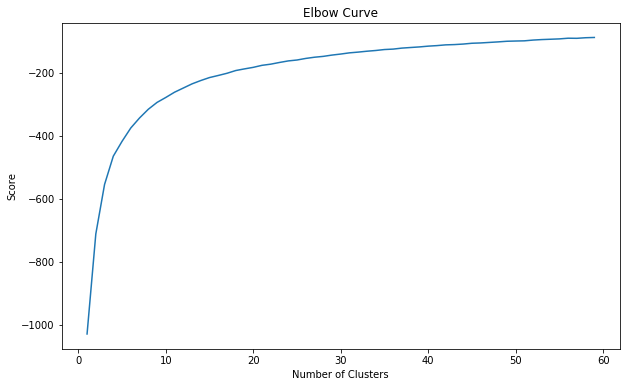

In [123]:
import pandas as pd

col_names =  ['Heave', 'North', 'West']
data  = pd.DataFrame(columns = col_names)
data.Heave = Heave
data.North = North
data.West = West

from sklearn.cluster import KMeans

n_cluster = range(1, 60)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

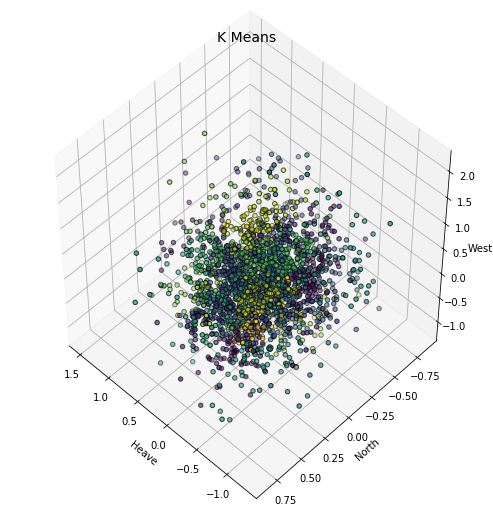

In [124]:
from mpl_toolkits.mplot3d import Axes3D

X = data[['Heave', 'North', 'West']]
X = X.reset_index(drop=True)
km = KMeans(n_clusters=40) # <---------------------------- Clusters == 40!!!
km.fit(X)
km.predict(X)
labels = km.labels_
#Plotting
fig = plt.figure(1, figsize=(7,7))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2],
          c=labels.astype(np.float), edgecolor="k")
ax.set_xlabel("Heave")
ax.set_ylabel("North")
ax.set_zlabel("West")
plt.title("K Means", fontsize=14);

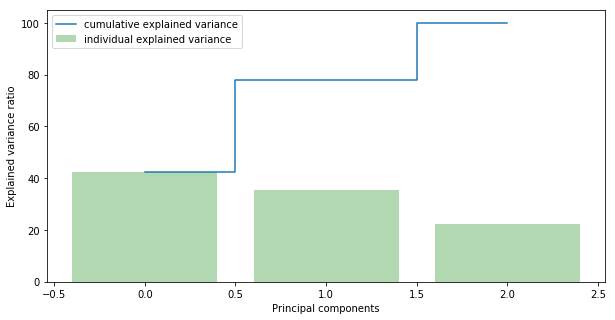

In [125]:
from sklearn.preprocessing import StandardScaler

X = data.values
X_std = StandardScaler().fit_transform(X)
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key = lambda x: x[0], reverse= True)
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show();

In [126]:
from scipy import linalg

def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
##        distance.set_value(i, linalg.norm(Xa-Xb))
        distance.at[i] = linalg.norm(Xa-Xb)
        
    return distance

outliers_fraction = 0.01

# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data1, kmeans[59])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
data['anomaly1'] = (distance >= threshold).astype(int)

# visualisation of anomaly with cluster view
import plotly.graph_objects as go
import pandas as pd
import numpy as np

def SetColorLine(anomaly1):
    if(anomaly1 < 1):
        return "lightblue"
    else:
        return "red"
def SetColorPoint(anomaly1):    
    if(anomaly1 < 1):
        return "lightblue"
    else:
        return "red"

fig = go.Figure(data=go.Scatter3d(x=data.North, y=data.West, z=data.Heave,
    marker=dict(size=3,color=list(map(SetColorPoint,data.anomaly1))),
    line=dict(color=list(map(SetColorLine,data.anomaly1)),width=2), opacity=0.5))
   
fig.update_layout(title=HXV_File,
    width=900,height=600,
    margin=dict(l=5,r=5,b=15,t=25),
    autosize=False,
    scene=dict(
        xaxis=dict(gridcolor='rgb(230, 230,230)',
            zerolinecolor='rgb(230, 230,230)',
            showbackground=False),
        yaxis=dict(gridcolor='rgb(230, 230,230)',
            zerolinecolor='rgb(230, 230,230)',
            showbackground=False),
        zaxis=dict(gridcolor='rgb(230, 230,230)',
            zerolinecolor='rgb(230, 230,230)',
            showbackground=False),
            camera=dict(up=dict(x=0,y=0,z=1),
            eye=dict(x=1.25,y=1.25,z=1.25)),
        aspectratio = dict( x=1, y=1, z=0.7 ),aspectmode = 'manual'))

fig.update_layout(scene = dict(
                    xaxis_title='NORTH-SOUTH',
                    yaxis_title='EAST-WEST',
                    zaxis_title='HEAVE'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

IndexError: list index out of range

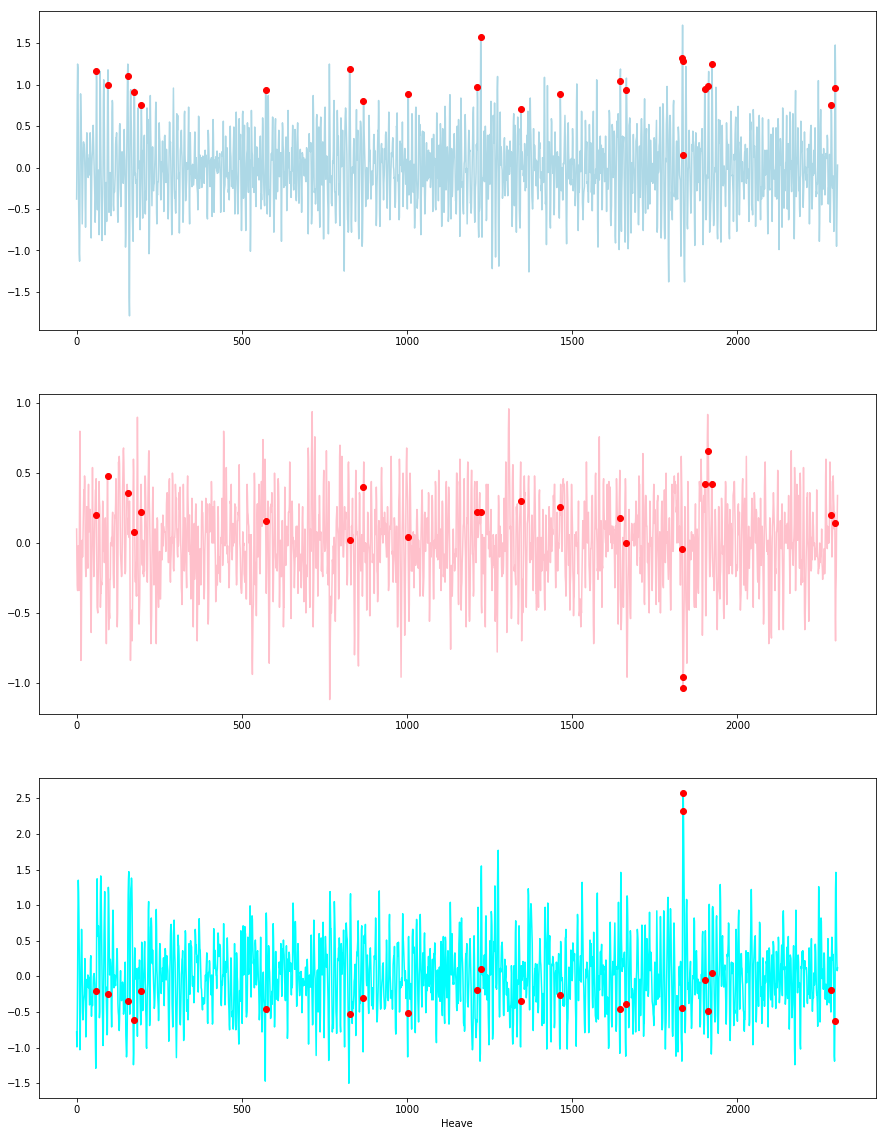

In [104]:
fig, (ax1,ax2,ax3) = plt.subplots(3, figsize=(15,20), facecolor=(1, 1, 1))
a = data.loc[data['anomaly1'] == 1]      

ax1.plot(data['Heave'], color='lightblue', label='Normal')
ax1.plot(a['Heave'], lw=0,marker='o',color='red', label='Anomaly')

ax2.plot(data['North'], color='pink', label='Normal')
ax2.plot(a['North'], lw=0,marker='o',color='red', label='Anomaly')

ax3.plot(data['West'], color='cyan', label='Normal')
ax3.plot(a['West'], lw=0,marker='o',color='red', label='Anomaly')

plt.xlabel('Heave')
plt.show();